**Question/need:** Can we predict the success (gross revenues, revenues per budget dollar, and/or oscar nominations) of proposed low-budget films (< $10 million) based on its characteristics? Are there different predictive characteristics for success in terms of gross revenues vs. oscar nominations? 

**Movie data:** I'm planning on using all movies (1980 - 2016) from boxofficemojo to investigate the impact of various characteristics on success. If I have time, I would also like to incorporate other variables, such as google searches and wikipedia page views, as well as critic and general public rating information from rottentomatoes. 

**Characteristics of each movie and/or other entities:** I'd like to investigate as many characteristics as possible during my first pass to determine which ones have the greatest predictive impact, and then dig in deeper to these characteristics. The features I'm most interested in are: genre, release date (month, if before a holiday weekend, if during Christmas holiday, if during summer), star power (a score that accounts for actors, director, and producers), production budget, and if there the movie has some preexisting popularity, either through a novel/play adaptation or if there's a prequel. I'll also investigate other features such as runtime, rating, and franchise, but I have a hunch that these will have a smaller impact. 

In [542]:
'''TO DOS:
- clean up genres and rating
- adjust budget for inflation'''

'TO DOS:\n- clean up genres and rating\n- adjust budget for inflation'

In [543]:
# storing
import pickle

# exploratory analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# regression
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation

from pprint import pprint

%matplotlib inline

### parse data

First, let's load the movie data into a dataframe and check the quality of our data.

In [544]:
with open('pickled_data/all-movies-data.pkl', 'r') as picklefile:
    all_movies_data = pickle.load(picklefile)

In [545]:
movies = pd.DataFrame(all_movies_data)

Time to do some cleaning...

In [546]:
# rename cols
movies.rename(columns = {'1-title': 'title', 
                         '2-release_date': 'release_date', 
                         '3-closing_date': 'closing_date'}, inplace = True)

In [683]:
# split actor, director, producer, writer columns
def get_person(peoplelist, i):
    '''Take a list of people and inde; return person at that index. Return blank if no list present.'''
    try:
        return peoplelist[i]
    except:
        return ''

def sep_people(df, person_type, num_people):
    '''For each column with list of people, split into n columns with one person in each column.
    Name new columns as person_type + n.
    
    Args:
    df -- name of dataframe
    person_type -- name of column (str)
    num_people -- number of columns to generate
    '''
    for n in range(num_people):
        df.loc[:, person_type + str(n+1)] = df.loc[:, person_type].apply(get_person, args=(n,))

# add seasons; rationale from http://www.boxofficemojo.com/seasonal/?chart=byseason
def get_season(date):
    '''Return season given month as int.'''
    months = (range(1, 13))
    seasons = ['winter', 'winter', 'spring', 'spring', 
           'summer', 'summer', 'summer', 'summer', 
           'fall', 'fall', 'holiday', 'holiday']
    seasons = dict(zip(months, seasons))
    try:
        return seasons[date.month]
    except:
        return ''
       
def add_season(df, func, new_col, old_col):
    '''Add corresponding season in new column based on release date.
    Args: 
    df -- data frame
    func -- function to apply
    new_col (str) -- name of new column (to store result of function)
    old_col (str) -- name of old column (on which to apply function)
    '''
    df[new_col] = df.loc[:, old_col].apply(func) 

# map raw genres to simple genres
def get_simple_genre(g):
    '''Recategorize raw genre into simple genre.'''
    raw_genres = tuple(by_genre.count().index)
    simple_genres = ['Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 
                 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 
                 'Animation', 'Comedy', 'Comedy', 'Comedy', 'Other', 
                 'Crime_Thriller', 'Crime_Thriller', 'Crime_Thriller', 'Crime_Thriller', 
                 'Documentary', 'Drama', 'Drama', 'Family', 'Family', 'Family', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Foreign', 'Foreign', 'Foreign', 'Historical', 'Historical', 
                 'Horror', 'Horror', 'Horror', 'Other', 'Musical', 'Musical', 'None', 
                 'Historical', 'Historical', 'Historical', 'Historical', 'Historical', 
                 'Romance', 'Romance', 'Romance', 'Romance', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Fantasy_Scifi', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Sports', 'Sports', 'Sports', 'Sports',  'Crime_Thriller', 
                 'None', 'War', 'War', 'War', 'Western', 'Western']
    try:
        return genres[g]
    except:
        return ''

def add_simple_genre(df):
    df['new_genre'] = df.loc[:, 'genre'].apply(get_simple_genre)
    
# clean up ratings
def get_clean_rating(r):
    rm_ratings = ['Unknown', 'Unrated', 'None', 'Not Yet Rated']
    return '' if r in rm_ratings else r

def clean_rating(df, func, new_col):
    '''Add new column to df with cleaned up rating. 
    Args:
    df -- df to work on
    func -- function to apply
    new col (str) -- name of new column to create for cleaned up rating
    '''
    df[new_col] = df.loc[:, 'rating'].apply(func)
    
# add roi
def add_roi(df):
    df['dom_roi'] = df.loc[:, 'dom_total_gross'] / df.loc[:, 'budget']
    df['intl_roi'] = df.loc[:, 'intl_total_gross'] / df.loc[:, 'budget']
    
# add total time in theaters - not necessary if we have theaters?
def add_in_theaters_time(df):
    try:
        df['time_in_theaters'] = df.loc[:, 'closing_date'] - df.loc[:, 'release_date']
    except:
        df['time_in_theaters'] = ''

In [684]:
sep_people(movies, 'director', 3)
sep_people(movies, 'actors', 5)
sep_people(movies, 'writers', 2)
sep_people(movies, 'producers', 3)
add_season(movies, get_season, 'season', 'release_date')
clean_rating(movies, get_clean_rating, 'clean_rating')

In [631]:
add_simple_genre(movies) # try not to rerun this guy, takes a while

In [632]:
# pickle the parsed df
with open('pickled_data/parsed-data.pkl', 'w') as picklefile:
    pickle.dump(movies, picklefile)

Since we're interested in budget data, let's check to see how many movies of the 16,100 total movies have budget data.

In [550]:
movies.budget.count()

2875

Only 2,874 out of 16,100 movies have budget data. That's only 17.9% of the entire dataset! Let's take a closer look at movies with budget data.

In [633]:
# drop movies without budget data 
only_budget = movies[pd.notnull(movies['budget'])]

In [634]:
### ONLY APPLICABLE TO MOVIES WITH BUDGETS

# adjust to 2015 dollars 
def get_infl_rate(startyear, endyear):
    '''Return inflation rate to 2015 dollars. 
    Args:
    startyear (float) -- start year
    endyear (int) -- end year
    Returns:
    infl (float) -- inflation rate
    '''
    cpi = pd.read_csv('cpi-data.csv')
    cpi.set_index('YEAR', inplace = True)
    if endyear > 2015:
        return float('NaN')
    else:
        try:
            cpiend = float(cpi.loc[endyear, 'AVE.'])
            cpistart = float(cpi.loc[int(startyear), 'AVE.'])
            infl = ((cpiend - cpistart) / cpistart) 
            return (1.0 + infl)
        except:
            return float('NaN')
    
def add_infl_rate(df):
    # add release year
    try:
        df['release_year'] = df['release_date'].apply(lambda x: x.year)
    except:
        df['release_year'] = None
    df['infl_rate'] = df['release_year'].apply(get_infl_rate, args=(2015,))
    
def add_adj_budget(df):
    df['budget_adj'] = df.loc[:, 'budget'] * df.loc[:, 'infl_rate']
    df['budget_adj'] = df['budget_adj'].fillna(0.0).astype(int)

# add roi calculations
def get_dom_roi(df):
    df['dom_roi'] = (df['dom_total_gross'] - df['budget'])/ df['budget']

def get_intl_roi(df):
    df['intl_roi'] = (df['intl_total_gross'] - df['budget'])/ df['budget']

In [635]:
add_infl_rate(only_budget)
add_adj_budget(only_budget)
get_dom_roi(only_budget)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

Let's look at lower budget movies that have been released in the past 15 years. 

In [555]:
# set assumptions
budget_threshold = 30000000
year_threshold = '1990'

In [636]:
# get only low budget (<$10m) films
low_budget = only_budget[only_budget['budget_adj'] < budget_threshold]
low_budget = low_budget[low_budget['budget_adj'] > 0] # find a better way to write this
low_budget.shape

(1158, 39)

In [637]:
# get only movies since 2000
newer_movies = low_budget[low_budget['release_date'] >= datetime.strptime(year_threshold, '%Y')]
newer_movies.shape

(1085, 39)

### explore high-level features

Season of release vs. mean adjusted domestic total gross. 

In [558]:
def plot_category(cat, y, df):
    '''Make bar plot of categorical features.
    Args: 
    y (str) -- name of column of independent variable
    cat (str) -- name of categorical feature
    df (var) -- name of df'''
    grouped = df.groupby(cat)
    grouped[y].mean().plot(kind = 'bar')
    plt.ylabel('mean %s' %y)
    plt.title('%s vs. %s' %(cat, y))
    plt.show()

def plot_continuous(cat, y, df):
    '''Make scatter plot of continuous features. 
    Args: 
    y (str) -- name of column of independent variable
    cat (str) -- name of categorical feature
    df (var) -- name of df'''
    df.plot(kind = 'scatter', 
             x = cat, 
             y = y, 
             figsize = (8, 5), 
             alpha = 0.5)
    plt.title('%s vs. %s' %(cat, y))
    plt.show()

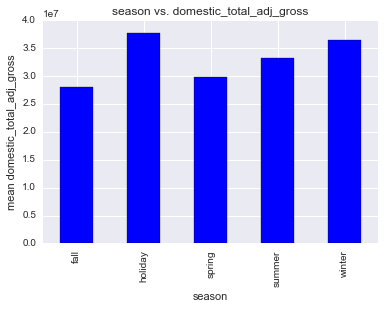

In [559]:
plot_category('season', 'domestic_total_adj_gross', newer_movies)

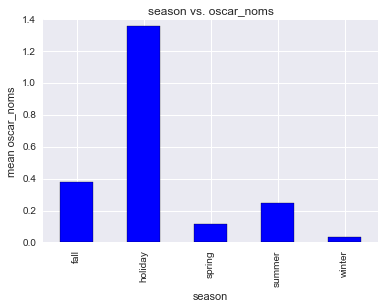

In [560]:
plot_category('season', 'oscar_noms', newer_movies)

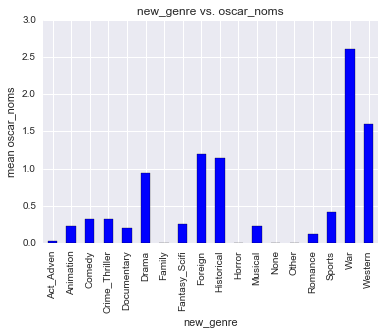

In [638]:
plot_category('new_genre', 'oscar_noms', newer_movies)

Genre vs. mean adjusted domestic total gross. 

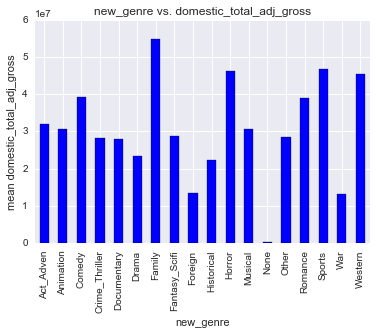

In [639]:
plot_category('new_genre', 'domestic_total_adj_gross', newer_movies)

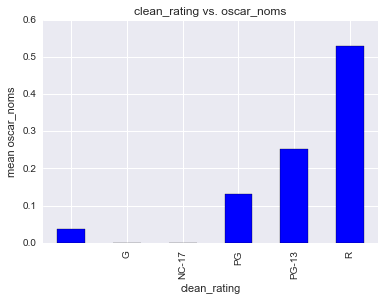

In [652]:
plot_category('clean_rating', 'oscar_noms', train)

Budget vs. domestic total gross.

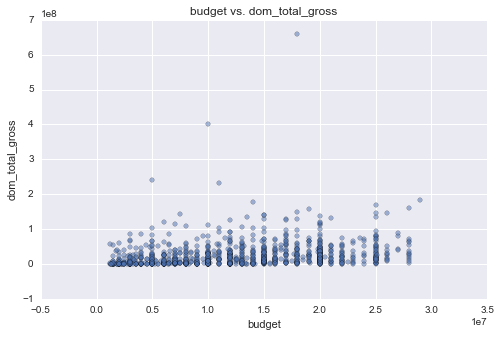

In [565]:
plot_continuous('budget', 'dom_total_gross', newer_movies)

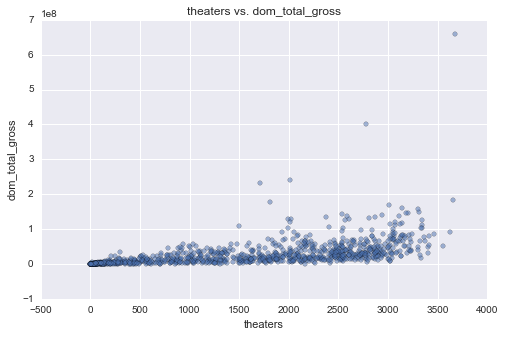

In [566]:
plot_continuous('theaters', 'dom_total_gross', newer_movies)

### cross-validation set up

In [605]:
# assumptions
trainyr_max = 2011.0
cvyr = [2012.0, 2013.0]
testyr = [2014.0, 2015.0]

In [578]:
newer_movies.shape

(1085, 39)

In [584]:
type(newer_movies.loc[27, 'release_year'])

numpy.float64

In [667]:
train = newer_movies[newer_movies['release_year'] <= trainyr_max]
train.shape

(899, 39)

In [668]:
cv = newer_movies[newer_movies['release_year'].isin(cvyr)]
cv.shape

(91, 39)

In [669]:
test = newer_movies[newer_movies['release_year'].isin(testyr)]
test.shape

(95, 39)

In [ ]:
# # some more checks
# train.groupby('release_year').count()
# cv.groupby('release_year').count()
# test.groupby('release_year').count()

In [611]:
# check if they add up
print train.shape[0] + cv.shape[0] + test.shape[0] == newer_movies.shape[0]

# check percentages
print 'train as % of total: ', float(train.shape[0]) / float(newer_movies.shape[0])
print 'cv as % of total: ', float(cv.shape[0]) / float(newer_movies.shape[0])
print 'test as % of total: ', float(test.shape[0]) / float(newer_movies.shape[0])

True
train as % of total:  0.828571428571
cv as % of total:  0.0838709677419
test as % of total:  0.0875576036866


### investigate predictive variables for adj domestic total gross

In [ ]:
y = newer_movies['dom_total_gross']
X = newer_movies['budget']

In [569]:
gross = smf.ols(formula="dom_roi ~ new_genre + clean_rating", 
                  data = newer_movies).fit()

In [570]:
gross.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                dom_roi   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     4.026
Date:                Mon, 25 Jan 2016   Prob (F-statistic):           3.54e-08
Time:                        15:58:02   Log-Likelihood:                -3048.3
No. Observations:                1078   AIC:                             6135.
Df Residuals:                    1059   BIC:                             6229.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                      -2.1550      0.943     -2.286      0.022        -4.005    -0.305
new_genre[T.Act_Adven]          1.3817      0.797      1.734      0.083        -0.182     2.945
new_genre[T.Animation]          0.7016      1.221      0.574      0.566        -1.695     3.098
new_genre[T.Comedy]             2.2734      0.658      3.454      0.001         0.982     3.565
new_genre[T.Crime_Thriller]     2.1027      0.730      2.880      0.004         0.670     3.536
new_genre[T.Documentary]        3.0509      1.235      2.470      0.014         0.627     5.474
new_genre[T.Drama]              1.9791      0.677      2.922      0.004         0.650     3.308
new_genre[T.Family]             1.2970      1.068      1.214      0.225        -0.800     3.394
new_genre[T.Fantasy_Scifi]      2.6619      0.931      2.858      0.004         0.834     4.490
new_genre[T.Foreign]            1.2154      0.977      1.243      0.214        -0.703     3.133
new_genre[T.Historical]         0.8256      0.870      0.949      0.343        -0.881     2.532
new_genre[T.Horror]             4.4371      0.709      6.259      0.000         3.046     5.828
new_genre[T.Other]              1.5507      0.807      1.921      0.055        -0.034     3.135
new_genre[T.Romance]            2.4389      0.764      3.191      0.001         0.939     3.938
clean_rating[T.G]               2.7530      1.436      1.917      0.056        -0.065     5.571
clean_rating[T.NC-17]          -0.3608      2.010     -0.180      0.858        -4.305     3.583
clean_rating[T.PG]              2.2108      0.929      2.380      0.017         0.388     4.034
clean_rating[T.PG-13]           1.4427      0.841      1.715      0.087        -0.208     3.094
clean_rating[T.R]               1.1956      0.821      1.457      0.145        -0.414     2.806
==============================================================================
Omnibus:                     1184.810   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            83791.807
Skew:                           5.388   Prob(JB):                         0.00
Kurtosis:                      44.825   Cond. No.                         23.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [648]:
train.groupby('new_genre').count()

,title,release_date,closing_date,actors,budget,director,distributor,dom_total_gross,domestic_total_adj_gross,genre,...,writers2,producers1,producers2,producers3,season,clean_rating,release_year,infl_rate,budget_adj,dom_roi
new_genre,,,,,,,,,,,,,,,,,,,,,
Act_Adven,47,47,32,47,47,47,47,46,46,47,...,47,47,47,47,47,47,47,47,47,46
Animation,16,16,12,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
Comedy,211,211,148,211,211,211,211,209,209,211,...,211,211,211,211,211,211,211,211,211,209
Crime_Thriller,76,76,48,76,76,76,76,75,74,76,...,76,76,76,76,76,76,76,76,76,75
Documentary,12,12,11,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
Drama,135,135,112,135,135,135,135,134,134,135,...,135,135,135,135,135,135,135,135,135,134
Family,26,26,17,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26
Fantasy_Scifi,27,27,14,27,27,27,27,26,26,27,...,27,27,27,27,27,27,27,27,27,26
Foreign,28,28,25,28,28,28,28,28,28,28,...,28,28,28,28,28,28,28,28,28,28


### investigate oscar nominations

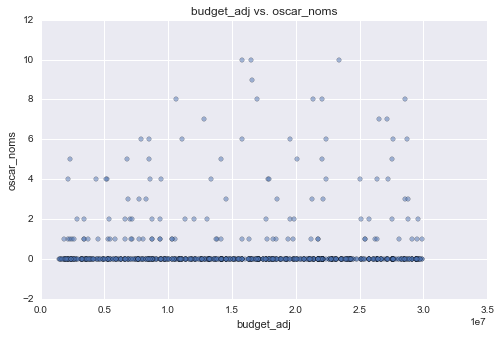

In [617]:
plot_continuous('budget_adj', 'oscar_noms', train)

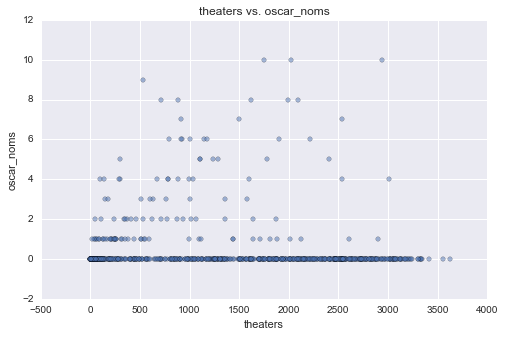

In [624]:
plot_continuous('theaters', 'oscar_noms', train)

In [650]:
oscars.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             oscar_noms   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     7.380
Date:                Mon, 25 Jan 2016   Prob (F-statistic):           6.84e-25
Time:                        16:48:12   Log-Likelihood:                -1427.8
No. Observations:                 890   AIC:                             2912.
Df Residuals:                     862   BIC:                             3046.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                      -0.6218      0.324     -1.920      0.055        -1.257     0.014
season[T.holiday]               0.7503      0.136      5.516      0.000         0.483     1.017
season[T.spring]               -0.2606      0.127     -2.057      0.040        -0.509    -0.012
season[T.summer]               -0.0993      0.117     -0.850      0.395        -0.329     0.130
season[T.winter]               -0.2677      0.139     -1.926      0.054        -0.540     0.005
new_genre[T.Animation]          0.4843      0.391      1.239      0.216        -0.283     1.252
new_genre[T.Comedy]             0.1498      0.202      0.743      0.458        -0.246     0.545
new_genre[T.Crime_Thriller]     0.3317      0.234      1.419      0.156        -0.127     0.791
new_genre[T.Documentary]        0.4449      0.403      1.104      0.270        -0.346     1.236
new_genre[T.Drama]              0.7958      0.216      3.680      0.000         0.371     1.220
new_genre[T.Family]             0.3467      0.341      1.017      0.309        -0.322     1.016
new_genre[T.Fantasy_Scifi]      0.1786      0.303      0.589      0.556        -0.416     0.774
new_genre[T.Foreign]            1.2839      0.312      4.116      0.000         0.672     1.896
new_genre[T.Historical]         1.1635      0.268      4.340      0.000         0.637     1.690
new_genre[T.Horror]            -0.2086      0.222     -0.938      0.348        -0.645     0.228
new_genre[T.Musical]            0.2748      0.319      0.861      0.389        -0.351     0.901
new_genre[T.None]               0.1567      0.268      0.586      0.558        -0.368     0.682
new_genre[T.Other]              0.2365      0.648      0.365      0.715        -1.035     1.508
new_genre[T.Romance]            0.2535      0.233      1.090      0.276        -0.203     0.710
new_genre[T.Sports]             0.5991      0.342      1.754      0.080        -0.071     1.270
new_genre[T.War]                3.0205      0.641      4.710      0.000         1.762     4.279
new_genre[T.Western]            1.2902      0.580      2.226      0.026         0.152     2.428
clean_rating[T.G]              -0.1134      0.457     -0.248      0.804        -1.011     0.785
clean_rating[T.NC-17]          -0.2097      0.605     -0.347      0.729        -1.398     0.978
clean_rating[T.PG]              0.1009      0.304      0.332      0.740        -0.496     0.698
clean_rating[T.PG-13]           0.3337      0.274      1.218      0.224        -0.204     0.871
clean_rating[T.R]               0.6334      0.262      2.414      0.016         0.118     1.148
theaters                        0.0001   4.91e-05      2.973      0.003      4.96e-05     0.000
==============================================================================
Omnibus:                    

In [671]:
# clean up oscars model a bit
'''things to clean:
- rating: R vs. not R 
- seasons: holiday, winter, other 
- genres: draama, foreign, historical + need to split other back out...'''

def split_r_rating(r):
    return r if r == 'R' else 'Not R'

clean_rating(train, split_r_rating, 'r_rating')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [679]:
oscars = smf.ols(formula="oscar_noms ~ season", data = train).fit()

In [680]:
oscars.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             oscar_noms   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     22.24
Date:                Mon, 25 Jan 2016   Prob (F-statistic):           1.59e-17
Time:                        17:42:11   Log-Likelihood:                -1488.9
No. Observations:                 899   AIC:                             2988.
Df Residuals:                     894   BIC:                             3012.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             0.3496      0.085      4.134      0.000         0.184     0.516
season[T.holiday]     0.9424      0.138      6.846      0.000         0.672     1.213
season[T.spring]     -0.2253      0.129     -1.743      0.082        -0.479     0.028
season[T.summer]     -0.0818      0.118     -0.693      0.488        -0.313     0.150
season[T.winter]     -0.3183      0.141     -2.263      0.024        -0.594    -0.042
==============================================================================
Omnibus:                      770.150   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15934.157
Skew:                           3.979   Prob(JB):                         0.00
Kurtosis:                      22.028   Cond. No.                         5.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [659]:
train.head()ratin

,title,release_date,closing_date,actors,budget,director,distributor,dom_total_gross,domestic_total_adj_gross,genre,...,producers1,producers2,producers3,season,new_genre,clean_rating,release_year,infl_rate,budget_adj,dom_roi
46,Accepted,2006-08-18,2006-10-19,"[Justin Long, Blake Lively, Jonah Hill, Kellan...",23000000,[Steve Pink],Universal,36323505,48246500,Comedy,...,Michael Bostick,Tom Shadyac,,summer,Comedy,Not R,2006,1.175680,27040629,0.579283
54,Ace Ventura: Pet Detective,1994-02-04,NaT,"[Jim Carrey, Courteney Cox]",15000000,[Tom Shadyac],Warner Bros.,72217396,150308900,Comedy,...,Gary Barber,James G. Robinson,,winter,Comedy,Not R,1994,1.599305,23989574,3.814493
70,Adaptation.,2002-12-06,2003-05-22,"[Nicolas Cage, Meryl Streep, Chris Cooper, Bri...",19000000,[Spike Jonze],Sony / Columbia,22498520,32626700,Comedy,...,,,,holiday,Comedy,R,2002,1.317640,25035151,0.184133
123,Affliction,1998-12-30,NaT,[Willem Dafoe],6000000,[Paul Schrader],Lions Gate,6330054,10844500,Drama,...,,,,holiday,Drama,R,1998,1.454092,8724552,0.055009
207,Akeelah and the Bee,2006-04-28,2006-07-20,"[Laurence Fishburne, Angela Bassett, Keke Palmer]",8000000,,Lionsgate,18848430,25035300,Drama,...,,,,spring,Drama,Not R,2006,1.175680,9405436,1.356054


In [ ]:
train['rating2'] = train['clean_rating'].apply

#### begin workspace for testing genre categorization

In [18]:
# original genre categories
raw_genres = tuple(by_genre.count().index)
print raw_genres

('Action', 'Action / Adventure', 'Action / Crime', 'Action Comedy', 'Action Drama', 'Action Fantasy', 'Action Horror', 'Action Thriller', 'Adventure', 'Adventure Comedy', 'Animation', 'Comedy', 'Comedy / Drama', 'Comedy Thriller', 'Concert', 'Crime', 'Crime Comedy', 'Crime Drama', 'Crime Thriller', 'Documentary', 'Drama', 'Drama / Thriller', 'Family', 'Family Adventure', 'Family Comedy', 'Fantasy', 'Fantasy Comedy', 'Fantasy Drama', 'Foreign', 'Foreign / Action', 'Foreign / Horror', 'Historical Drama', 'Historical Epic', 'Horror', 'Horror Comedy', 'Horror Thriller', 'IMAX', 'Music Drama', 'Musical', 'None', 'Period Action', 'Period Adventure', 'Period Comedy', 'Period Drama', 'Period Horror', 'Romance', 'Romantic Adventure', 'Romantic Comedy', 'Romantic Thriller', 'Sci-Fi', 'Sci-Fi Action', 'Sci-Fi Adventure', 'Sci-Fi Comedy', 'Sci-Fi Fantasy', 'Sci-Fi Horror', 'Sci-Fi Thriller', 'Sports', 'Sports Action', 'Sports Comedy', 'Sports Drama', 'Thriller', 'Unknown', 'War', 'War Drama', 'War

In [33]:
print len(raw_genres)

67


In [626]:
# code simple genres 
simple_genres = ['Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 
                 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 
                 'Animation', 'Comedy', 'Comedy', 'Comedy', 'Other', 
                 'Crime_Thriller', 'Crime_Thriller', 'Crime_Thriller', 'Crime_Thriller', 
                 'Documentary', 'Drama', 'Drama', 'Family', 'Family', 'Family', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Foreign', 'Foreign', 'Foreign', 'Historical', 'Historical', 
                 'Horror', 'Horror', 'Horror', 'Other', 'Musical', 'Musical', 'None', 
                 'Historical', 'Historical', 'Historical', 'Historical', 'Historical', 
                 'Romance', 'Romance', 'Romance', 'Romance', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Fantasy_Scifi', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Sports', 'Sports', 'Sports', 'Sports',  'Crime_Thriller', 
                 'None', 'War', 'War', 'War', 'Western', 'Western']

In [627]:
# count how many genres
print set(simple_genres)
print len(set(simple_genres))

set(['Romance', 'None', 'Family', 'Sports', 'Horror', 'Other', 'Act_Adven', 'Foreign', 'Drama', 'Animation', 'War', 'Western', 'Historical', 'Crime_Thriller', 'Fantasy_Scifi', 'Comedy', 'Documentary', 'Musical'])
18


In [628]:
genres = dict(zip(raw_genres, simple_genres))

In [629]:
pprint(genres)

{'Action': 'Act_Adven',
 'Action / Adventure': 'Act_Adven',
 'Action / Crime': 'Act_Adven',
 'Action Comedy': 'Act_Adven',
 'Action Drama': 'Act_Adven',
 'Action Fantasy': 'Act_Adven',
 'Action Horror': 'Act_Adven',
 'Action Thriller': 'Act_Adven',
 'Adventure': 'Act_Adven',
 'Adventure Comedy': 'Act_Adven',
 'Animation': 'Animation',
 'Comedy': 'Comedy',
 'Comedy / Drama': 'Comedy',
 'Comedy Thriller': 'Comedy',
 'Concert': 'Other',
 'Crime': 'Crime_Thriller',
 'Crime Comedy': 'Crime_Thriller',
 'Crime Drama': 'Crime_Thriller',
 'Crime Thriller': 'Crime_Thriller',
 'Documentary': 'Documentary',
 'Drama': 'Drama',
 'Drama / Thriller': 'Drama',
 'Family': 'Family',
 'Family Adventure': 'Family',
 'Family Comedy': 'Family',
 'Fantasy': 'Fantasy_Scifi',
 'Fantasy Comedy': 'Fantasy_Scifi',
 'Fantasy Drama': 'Fantasy_Scifi',
 'Foreign': 'Foreign',
 'Foreign / Action': 'Foreign',
 'Foreign / Horror': 'Foreign',
 'Historical Drama': 'Historical',
 'Historical Epic': 'Historical',
 'Horror': '

#### </ end genre testing workspace >

In [93]:
pd.get_dummies(newer_movies, columns = ['genre']).head()

,1-title,2-release_date,3-closing_date,actors,budget,director,distributor,dom_total_gross,intl_total_gross,oscar_noms,...,genre_Romantic Thriller,genre_Sci-Fi Action,genre_Sci-Fi Horror,genre_Sci-Fi Thriller,genre_Sports Comedy,genre_Sports Drama,genre_Thriller,genre_Unknown,genre_War,genre_Western
123,Affliction,1998-12-30,NaT,[Willem Dafoe],6000000,[Paul Schrader],Lions Gate,6330054,NaN,2,...,0,0,0,0,0,0,0,0,0,0
200,Airplane!,1980-06-27,NaT,[Leslie Nielsen],3500000,"[Jim Abrahams, David Zucker, Jerry Zucker]",Paramount,83453539,NaN,0,...,0,0,0,0,0,0,0,0,0,0
207,Akeelah and the Bee,2006-04-28,2006-07-20,"[Laurence Fishburne, Angela Bassett, Keke Palmer]",8000000,None,Lionsgate,18848430,18948425,0,...,0,0,0,0,0,0,0,0,0,0
223,Albino Alligator,1997-01-17,1997-02-13,"[Matt Dillon, Viggo Mortensen]",6000000,None,Miramax,339379,NaN,0,...,0,0,0,0,0,0,0,1,0,0
289,All or Nothing,2002-10-25,NaT,"[Taraji P. Henson, Sally Hawkins]",9000000,[Mike Leigh],United Artists,201546,201546,0,...,0,0,0,0,0,0,0,1,0,0
